<a href="https://colab.research.google.com/github/LogeswaranSR/GAN-MNIST-Dataset/blob/main/GAN_Basic_MNIST_Dataset_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,LeakyReLU,Dropout,BatchNormalization
from tensorflow.keras.models import Model
from keras.optimizers import SGD, Adam

## **Importing the MNIST Dataset.**

Here, MNIST dataset refers to the dataset of handwritten digits, stored in 28x28 image.

*mnist.load_data()* function imports the training data of 60,000 images alongwith a test data of 10,000 images.

In [2]:
mnist=tf.keras.datasets.mnist
(xtr,ytr),(xte,yte)=mnist.load_data()
xtr,xte=xtr/255.0 * 2 - 1,xte/255.0 * 2 - 1

11490434/11490434 [==============================] - 0s 0us/step


The dimensions and count are declared here.

Then, the Training and Testing dataset is reshaped such that it contains data of 784(28*28) pixels in a single array.

In [3]:
N, H, W=xtr.shape
D=H*W
xtr=xtr.reshape(-1,D)
xte=xte.reshape(-1,D)

Here, we declare the structure for Generator and Discriminator model.

Generator consists of an Input layer of latent_dim (In this case, 100) nodes, followed by a series of Fully connected Hidden Layers and Batch Normalization Layers. Their activation function is LeakyReLU, in order to mainly prevent the network from Dying State. The final output layer consists of D nodes, where D denotes the dimensions of the images. tanh function is used as activation function here, so as to generate values from 0 to 255

Discriminator model is a Feed-forward Neural Network, with an Input layer of D nodes, and an Output layer of 1 node. The output node uses Sigmoid function to denote the probability of the input image; 0 denotes it is fake, and 1 denotes it is real.

In [4]:
latent_dim=100
def generatormodel(latent_dim, D):
    i=Input(shape=(latent_dim,))
    x=Dense(256, activation=LeakyReLU(alpha=0.2))(i)
    x=BatchNormalization(momentum=0.7)(x)
    x=Dense(512, activation=LeakyReLU(alpha=0.2))(x)
    x=BatchNormalization(momentum=0.7)(x)
    x=Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
    x=BatchNormalization(momentum=0.7)(x)
    x=Dense(D,activation='tanh')(x)
    model=Model(inputs=i,outputs=x)
    return model

def discriminatormodel(img_size):
    i=Input(shape=(img_size,))
    x=Dense(512,activation=LeakyReLU(alpha=0.2))(i)
    x=Dense(256,activation=LeakyReLU(alpha=0.2))(x)
    x=Dense(1,activation='sigmoid')(x)
    model=Model(inputs=i,outputs=x)
    return model

def sample_images(epoch):
    rows,cols=(5,5)
    noise=np.random.randn(rows*cols,latent_dim)
    imgs=generator.predict(noise)

    imgs= 0.5 * imgs + 0.5

    fig,axs=plt.subplots(rows,cols)
    idx=0
    for i in range(rows):
        for j in range(cols):
            axs[i,j].imshow(imgs[idx].reshape(H,W),cmap='gray')
            axs[i,j].axis('off')
            idx+=1
    fig.savefig("gan_images/%d.png"%epoch)
    plt.close()

As you can see above, A function *sample_images* is declared.

sample_images is mainly used to store the output of the generator at a specific epoch. The function uses generator to generate 25 fake images and store it in the given folder as a .png image.

## Discriminator

The Discriminator model is, now, declared and compiled as shown below.
It is compiled with the *Adam* optimizer, and *binary_crossentropy* as a loss function.

In [5]:
discriminator=discriminatormodel(D)
discriminator.compile(loss='binary_crossentropy',optimizer=Adam(0.0002,0.5),metrics=['accuracy'])

## Generator

The Generator model is, now declared.

In [6]:
generator=generatormodel(latent_dim, D)

In [7]:
z=Input(shape=(latent_dim,))
img=generator(z)
discriminator.trainable=False
fake_pred=discriminator(img)

In [8]:
combinedgenerator=Model(z,fake_pred)
combinedgenerator.compile(loss='binary_crossentropy',optimizer=Adam(0.0002,0.5))

In [9]:
batch_size=32
epochs=12000
sample_period=200
ones=np.ones(batch_size)
zeros=np.zeros(batch_size)

d_losses=[]
g_losses=[]

In [10]:
if not os.path.exists('gan_images'):
    os.makedirs('gan_images')

In [11]:
# Training time: 41 mins
for epoch in range(epochs):
    idx=np.random.randint(0,xtr.shape[0],batch_size)
    real_imgs=xtr[idx]

    noise=np.random.randn(batch_size, latent_dim)
    fake_imgs=generator.predict(noise)

    d_loss_real, d_acc_real=discriminator.train_on_batch(real_imgs, ones)
    d_loss_fake, d_acc_fake=discriminator.train_on_batch(fake_imgs, zeros)

    d_loss = 0.5 * (d_loss_real+d_loss_fake)
    d_acc = 0.5 * (d_acc_real + d_acc_fake)

    noise=np.random.randn(batch_size, latent_dim)
    g_loss=combinedgenerator.train_on_batch(noise, ones)

    noise=np.random.randn(batch_size, latent_dim)
    g_loss=combinedgenerator.train_on_batch(noise, ones)

    d_losses.append(d_loss)
    g_losses.append(g_loss)

    if epoch%100==0:
        print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")
    
    if epoch % sample_period==0:
        sample_images(epoch)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 26ms/step
epoch: 7101/12000, d_loss: 0.70, d_acc: 0.50, g_loss: 0.85
1/1 [==============================] - 0s 23ms/step
epoch: 7201/12000, d_loss: 0.68, d_acc: 0.56, g_loss: 0.79
1/1 [==============================] - 0s 24ms/step
epoch: 7301/12000, d_loss: 0.72, d_acc: 0.47, g_loss: 0.84
1/1 [==============================] - 0s 44ms/step
epoch: 7401/12000, d_loss: 0.71, d_acc: 0.56, g_loss: 0.82
1/1 [==============================] - 0s 24ms/step
epoch: 7501/12000, d_loss: 0.69, d_acc: 0.59, g_loss: 0.79
1/1 [==============================] - 0s 25ms/step
epoch: 7601/12000, d_loss: 0.64, d_acc: 0.64, g_loss: 0.83
1/1 [==============================] - 0s 34ms/step
epoch: 7701/12000, d_loss: 0.66, d_acc: 0.62, g_loss: 0.81
1/1 [==============================] - 0s 23ms/step
epoch: 7801/12000, d_loss: 0.67, d_acc: 0.56, g_loss: 0.77
1/1 [==============================] - 0s 25ms/step
epoch: 79

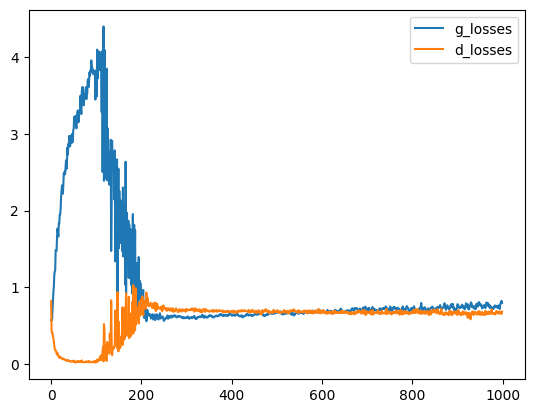

In [12]:
plt.plot(g_losses[:1000], label='g_losses')
plt.plot(d_losses[:1000], label='d_losses')
plt.legend()

In [13]:
generator.save(r'mnist_g.h5')
discriminator.save(r'mnist_d.h5')

In [14]:
sample_images(12000)

1/1 [==============================] - 0s 27ms/step


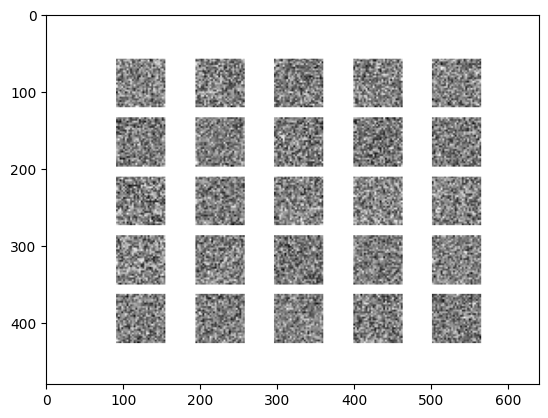

In [15]:
import cv2
im0=cv2.imread(r"/content/gan_images/0.png")
plt.imshow(im0)

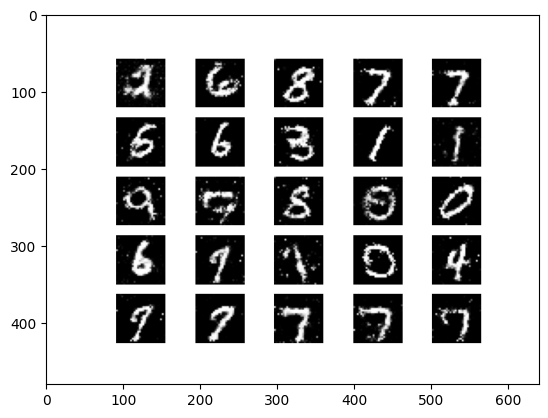

In [16]:
im12000=cv2.imread(r"/content/gan_images/12000.png")
plt.imshow(im12000)